# Lab 2: Timing, Ploting, and Big-O

Instructor: Sirasit Lochanachit

Course: 01526102 Data Sturctures and Algorithms


# Required Libraries

In [ ]:
import time
import timeit
import math
import random
import numpy as np
import matplotlib.pyplot as plt

## 1. Timing

The [`time`](https://docs.python.org/3/library/time.html#module-time) module contains functions for obtaining and interpreting the current system time (in seconds).

Technically, it is the time since the **epoch**, where time starts in 1 January 1970. 

In [6]:
import time
time.time()

1689125931.5799124

How many years since the epoch?

In [7]:
time.time() // (365 * 24 * 60 * 60)

53.0

What is the current local time? (Depends on timezone set in your machine)

In [8]:
time.localtime(time.time())

time.struct_time(tm_year=2023, tm_mon=7, tm_mday=12, tm_hour=8, tm_min=42, tm_sec=25, tm_wday=2, tm_yday=193, tm_isdst=0)

By taking start and stop "timestamps", we can measure the runtime of code:

In [10]:
start_time = time.time() # Record the starting time
########################
# Run your algorithm
########################
time.sleep(1)
end_time = time.time() # Record the ending time

running_time = end_time - start_time    # Record time executed

print(f"Time executed: {running_time:.5f} seconds")

Time executed: 1.01163 seconds


## 2. Building a stopwatch utility

We can build a utility function for timing the execution of a passed-in function:

In [11]:
def stopwatch(fn):
    start_time = time.time()
    fn()
    end_time = time.time()
    return end_time - start_time

In [17]:
sum(range(100000))

4999950000

In [18]:
stopwatch(sum(range(100000)))

TypeError: 'int' object is not callable

Passing a small anonymous function to another function

In [16]:
stopwatch(lambda: sum(range(100000)))

0.002002716064453125

While using a lambda is one possible approach, it limits us to passing in a function that must be called a certain way (e.g., with no arguments). We can make use of the `eval` function to evaluate an arbitrary string of Python code instead.

In [19]:
eval('1 + 2')

3

In [20]:
eval('sum(range(100000))')

4999950000

In [21]:
def stopwatch(stmt='pass'):
    start_time = time.time()
    eval(stmt)
    end_time = time.time()
    return end_time - start_time

In [22]:
stopwatch('sum(range(100000))')

0.0010006427764892578

To make timings more stable, we can run the passed-in function multiple times:

In [23]:
def stopwatch_rounds(stmt='pass', number=1):
    total = 0
    for _ in range(number):
        start_time = time.time()
        eval(stmt)
        end_time = time.time()
        total += end_time - start_time
    return total

Total timing of 1000 rounds

In [26]:
stopwatch_rounds('sum(range(10000))', number=1000)

0.07599735260009766

## 3. The `timeit` module

The [`timeit`](https://docs.python.org/3/library/timeit.html) module is a built-in library for measuring the execution of code passed in as a string.

In [35]:
import timeit
timeit.timeit('sum(range(1000))', number=1000)

0.013231299999461044

It also supports passing in "setup" code that is not timed.

In [36]:
timeit.timeit('sum(r)', 
              setup='r = range(1000)', 
              number=1000)

0.00769270000000688

We can easily use this to gather timings for multiple input values:

In [31]:
[timeit.timeit('sum(r)',
               setup=f'r = range({n})',
               number=1000)
 for n in range(1000, 11000, 1000)]

[0.015796200000295357,
 0.016830799999297597,
 0.022258699999838427,
 0.029361199999584642,
 0.032594199999948614,
 0.03898680000020249,
 0.04599620000044524,
 0.05229550000058225,
 0.05980290000024979,
 0.06802539999989676]

Sometimes we might want to make use of functions defined in our notebook in the timed/setup code passed to `timeit`. We need to use the `globals` argument for this:

In [32]:
def fib(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fib(n-1) + fib(n-2)

In [33]:
[fib(n) for n in range(15)]

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]

In [34]:
[timeit.timeit(f'fib({n})',
               number=1000,
               globals=globals()) # recall: "globals()" returns a dictionary of everything
                                  # defined in this module; timeit needs it to access `fib`
 for n in range(1, 15)]

[4.910000006930204e-05,
 0.00013440000020636944,
 0.00022600000011152588,
 0.00040050000006885966,
 0.0007034999998722924,
 0.0011893000000782195,
 0.0019409000005907728,
 0.003184000000146625,
 0.005403400000432157,
 0.010074400000121386,
 0.01647400000001653,
 0.02444149999973888,
 0.04077270000016142,
 0.06411279999974795]

### Magic timing commands

There are also "magic" notebook commands that can be used to time code -- they are `%time`, `%timeit`, and `%%timeit`

In [49]:
%time sum(range(200000))

CPU times: total: 0 ns
Wall time: 4 ms


19999900000

In [50]:
%timeit -n 1000 sum(range(200000))

2.57 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [51]:
%%timeit -n 1000

total = 0
for n in range(200000):
    total += n

4.24 ms ± 54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


It isn't as convenient to use the magic commands to get timings into a data structure (e.g., a list) for subsequent processing, though, so we will typically use the `timeit` module programmatically.

## 4. Drawing plots with `matplotlib`

The [matplotlib library](https://matplotlib.org) supports the creation of all sorts of visualizations. We will use it for drawing simple 2-dimensional plots.

The primary plotting function we will use is `matplotlib.pyplot.plot` ([full documentation here](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot)), which, when passed two "array-like" objects of equal length, will interpret and plot their contents as x and y axis coordinates. We will generally use tuples, lists, and ranges as array-like objects. Note that generators are *not* considered array-like by matplotlib.

Some examples (note that we use a semicolon after the call to `plot` to hide its return value):

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6] # set size of plot

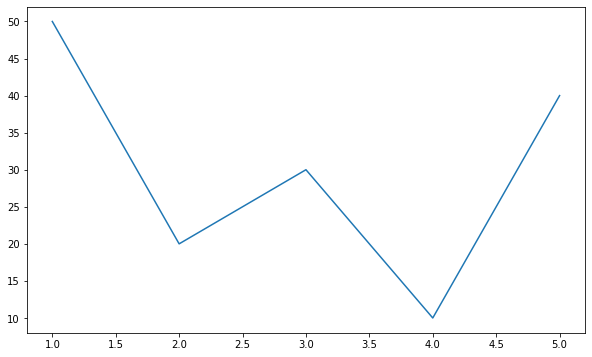

In [53]:
plt.plot([1, 2, 3, 4, 5], [50, 20, 30, 10, 40]);

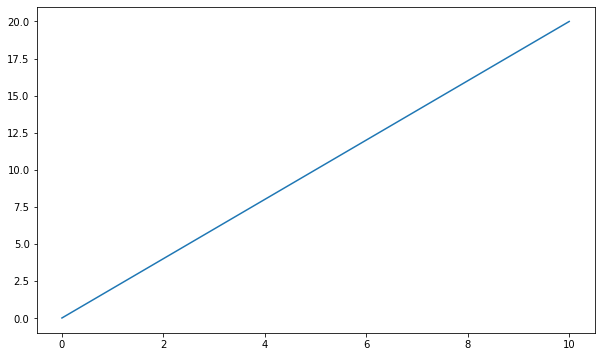

In [54]:
xs = range(11)
ys = [x*2 for x in xs]
plt.plot(xs, ys);

We can also provide an optional format string to `plot`, which controls marker, line-style, and color for the plot.

Here's a shortened list of options copied from the [full documentation of `plot`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot):

**Markers**

  - `.` : point marker
  - `o` : circle marker
  - `s` : square marker
  - `d` : diamond marker

**Line-styles**
 
  - `-` : solid line style
  - `--` : dashed line style
  - `:` : dotted line style

**Colors**

  - `k` : black
  - `r` : red
  - `g` : blue
  - `b` : green
  - `y` : yellow
  - `c` : cyan
  
Here are the above plots with some color and styling:

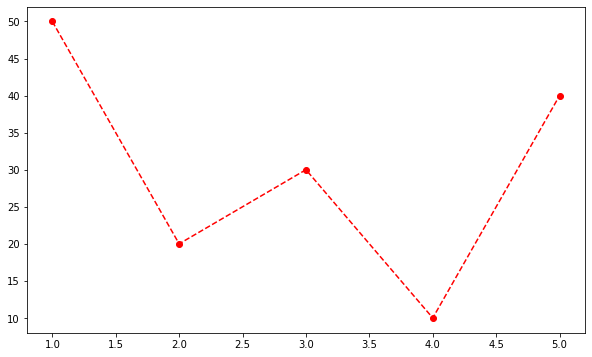

In [55]:
plt.plot([1, 2, 3, 4, 5], [50, 20, 30, 10, 40], 'o--r');

If we omit a line style, no connecting line is drawn between data points

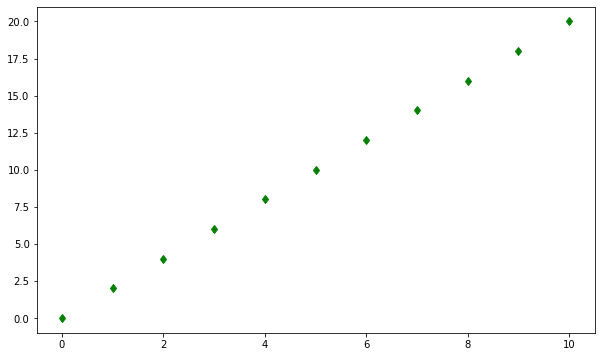

In [56]:
xs = range(11)
ys = [x*2 for x in xs]
plt.plot(xs, ys, 'dg');

Instead of regular `range` objects, which only allow for integral start/stop/step values, we typically prefer to use the [numpy library](https://numpy.org)'s `arange` and `linspace` functions with matplotlib. `arange` is like `range`, except we can use floating point values for start/stop/step. `linspace` lets us specify start and stop values (both inclusive), and the number of values to return in that interval.

Examples of `arange` and `linspace` calls (note that both functions return numpy arrays, which are iterable and can be passed to `plot`):

In [57]:
np.arange(0.5, 2.5, 0.1)

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4])

Obtain 41 values that are evenly spaced between 10 and 20

In [29]:
np.linspace(10, 20, 41)

array([10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 , 11.75, 12.  ,
       12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  , 14.25,
       14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 ,
       16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75,
       19.  , 19.25, 19.5 , 19.75, 20.  ])

In [58]:
np.linspace(1, 100000, 50, dtype=int) # we can specify the data type to coerce values into integers

array([     1,   2041,   4082,   6123,   8164,  10204,  12245,  14286,
        16327,  18368,  20408,  22449,  24490,  26531,  28572,  30612,
        32653,  34694,  36735,  38776,  40816,  42857,  44898,  46939,
        48980,  51020,  53061,  55102,  57143,  59184,  61224,  63265,
        65306,  67347,  69388,  71428,  73469,  75510,  77551,  79592,
        81632,  83673,  85714,  87755,  89796,  91836,  93877,  95918,
        97959, 100000])

`plot` can be called multiple times in the same cell to draw multiple lines in the same chart. Below we use this facility together with `linspace` and a handful of list comprehensions to plot some common runtime complexity bounding functions (more on that soon) over a small interval: 

# Lab 2-1

Given values of x between 0.1 and 4 in `xs` variable, produce a plot of running time complexity of 6 most important functions (except factorial)

* Plotting Factorial function can get ugly very fast (You can try it!)

In [ ]:
count = 100
xs = np.linspace(0.1, 4, count)

##########################
# Insert your code here #
##########################

plt.plot(xs, ys_const, 'c')
plt.plot(xs, ys_log, 'r')
plt.plot(xs, ys_linear, 'b')
plt.plot(xs, ys_linearithmic, 'g')
plt.plot(xs, ys_quadratic, 'y');
plt.plot(xs, ys_exponential, 'm');

## 5. Plotting timings

Plotting timing data collected from functions may help give us a sense of how their runtimes scale with increasing input sizes.

Text(0.5, 1.0, 'Running time of sum function on 100 rounds')

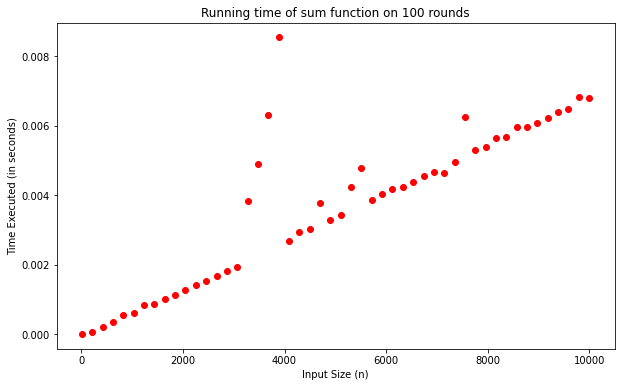

In [95]:
# runtimes for sum for increasing sizes of input

ns = np.linspace(10, 10000, 50, dtype=int)
ts = [timeit.timeit(f'sum(range({n}))', number=100)
      for n in ns]

plt.plot(ns, ts, 'or');
plt.xlabel('Input Size (n)')
plt.ylabel('Time Executed (in seconds)')
plt.title('Running time of sum function on 100 rounds')

Clearly, the runtime of `sum` is directly proportional to the number of values it operates on. 

If we assume a linear relationship, we can compute the average slope between adjacent data points to come up with an line of approximate fit that may help us predict the runtime of `sum`.

In [72]:
total = 0

for i in range(len(ns)-1):
    total += (ts[i+1] - ts[i]) / (ns[i+1] - ns[i]) # recall: slope = rise / run
    
avg_slope = total / (len(ns)-1)

In [73]:
avg_slope

6.889734711559732e-07

We can also use the statistics module to help us compute the mean:

In [74]:
import statistics
avg_slope = statistics.mean((ts[i+1] - ts[i]) / (ns[i+1] - ns[i]) for i in range(len(ns)-1))
avg_slope

6.889734711559731e-07

Add the slope line

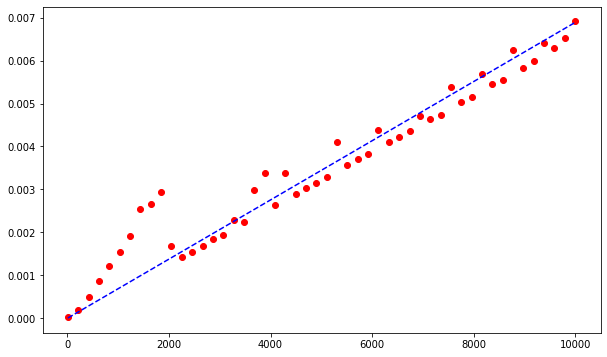

In [75]:
plt.plot(ns, ts, 'or')
plt.plot(ns, [avg_slope*n for n in ns], '--b');

## 6. Timing Examples

### Built-in list indexing

What is the runtime behavior of list-indexing?

Text(0.5, 1.0, 'Running time of list-indexing on 10000 rounds')

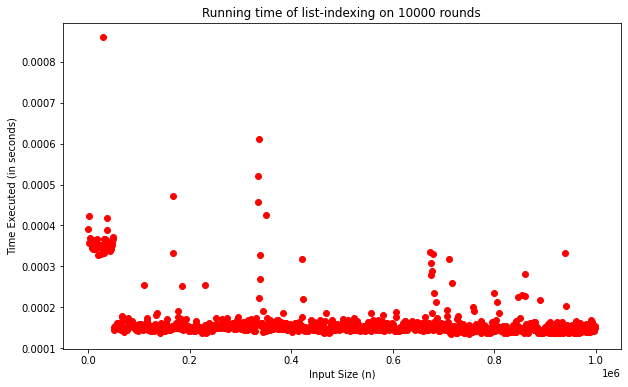

In [96]:
lst = list(range(1000000))
ns = np.linspace(0, len(lst), 1000, endpoint=False, dtype=int)
ts = [timeit.timeit(f'_ = lst[{n}]',
                    globals=globals(), 
                    number=10000) 
      for n in ns]

plt.plot(ns, ts, 'or');
plt.xlabel('Input Size (n)')
plt.ylabel('Time Executed (in seconds)')
plt.title('Running time of list-indexing on 10000 rounds')

Observation: accessing an element in a list by index -- *regardless of where in the list the element is located* -- takes a uniform/constant amount of time.

How? **A Python list uses an array as its backing data store.** Every "slot" in this array is a reference (i.e., a fixed-width address) to an object, and to access an element at a particular index, the underlying code:

1. Computes an *offset* into the array by multiplying the index by the size of a reference
2. Adds the computed offset to the *base address* of the array, giving us the address of the reference
3. Accesses the reference and uses it to load the associated element

Each of the steps above can be performed in constant time.

# Lab 2-2

### Linear Search

Write a function `linear_search` that accepts two inputs: a list and an integer
* It search for an input integer in a list one-by-one starting from the first zero index.
* If an element is found, return True
* Otherwise, it looks at the next index and repeatedly do this until the last element of the list.
    * If a list does not contain an input integer, return False

In [ ]:
def linear_search(lst:list, x:int):

    #######################
    # Insert your code here
    #######################

    pass

Testing your function on a list of 1 to 100 with a random shuffling of their positions

In [89]:
import random
lst = list(range(100))
random.shuffle(lst)

linear_search(lst, 10)

True

What is the runtime behavior of searching for an exist element in an unsorted list? Plot the graph to answer this.

* Input size (n) grows from 10 to 10000
* For each test, create a list from 0 to n, then shuffle the list to unsort it.
    * Each test should execute 100 rounds
* Your plot should include x and y label and a title

In [ ]:
ns1 = np.linspace(10, 10000, 100, dtype=int)


ts1 = None # Insert your code here


plt.plot(ns1, ts1, 'or');

What is the runtime behavior of searching for a non-exist element in an unsorted list? (Worst-case scenario)

* Input size (n) grows from 1000 to 10000
* Your plot should include x and y label and a title

In [ ]:
ns2 = np.linspace(1000, 10000, 100, dtype=int)

ts2 = None # Insert your code here

plt.plot(ns2, ts2, 'or');

## Combine both plot to compare running time

* Your plot should include x and y label and a title

After plotting, have a look between worst-case scenario and average-case

In [105]:
#Insert your code here
plt.legend(['Element is exist', 'Element is non-exist'])

# Lab 2-3 Intersect(a, b, c)

Write a function `isIntersect(a, b, c)` with 2 variations where a, b, c are list of length *n*
* Return True if list a, b, and c has a single element that is identical
* Return False otherwise

* Example Test Case
    * isIntersect([50, 20, 80], [40, 30, 20], [20, 70, 90])
        * Return True because 20 exists on all 3 lists
    * isIntersect([40, 60, 80, 100], [10, 30, 50, 60], [10, 20, 30, 40]) 
        * Return False because no any number that exist on all 3 lists

1. This function has an O($n^3$)

In [125]:
def isIntersect_1(a, b, c):
    #######################
    # Insert your code here
    #######################
    pass

2. This function has an O($n^2$)

In [126]:
def isIntersect_2(a, b, c):
    #######################
    # Insert your code here
    #######################
    pass

Create a random list of random length within a length of *n*
* The number elements in a list is randomly chosen from 1 to 100

In [122]:
#######################
# Insert your code here
#######################

## Combine both running time on a plot

* Your plot should include x and y label and a title

In [129]:
ns3 = np.linspace(10, 1000, 100, dtype=int)
ts3 = # Insert your code here

plt.plot(ns3, ts3, 'or');

ns4 = np.linspace(10, 1000, 100, dtype=int)
ts4 = # Insert your code here

plt.plot(ns4, ts4, 'or');

# Insert your code here
